Next steps:

- Analisis de contenido de tweets
- Analisis zona horaria de tweet (Posible?)
- Analisis de idioma de tweets
- Analisis de idioma de seguidores/mencionados de un usuario
- Analisis de contenido de seguidores/mencionados de un usuario
- Mejorar analisis de seguidores. Conservar seguidores aunque no pertenezcan al dataset? (Esto influye en si siguen gente popular por ejemplo)
- Mejorar analisis de mencionados. Conservar mencionados aunque no pertenezcan al datset? (Esto influye en si mencionan gente popular por ejemplo)


In [1]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from collections import OrderedDict
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import time
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
import re
def extract_oslom(filename):
    """Funcion que extrae las comunidades detectadas por OSLOM a las que pertence un vertice de la red."""
    clusters = {}
    hashtag_clusters = {}
    data = []
    with open(filename) as f:
        cluster = ""
        for line in f:
            m = re.search("^#module\s([0-9]+).*", line)
            #print line
            if (m is not None):
                cluster = int(m.group(1))
            else:
                l = line.replace('\n', ' ').strip().split(" ")
                l = list(map(int, l))
                clusters[cluster] = l
                for i in l:
                    if not i in hashtag_clusters:
                        hashtag_clusters[i] = set()
                    hashtag_clusters[i].add(cluster)
                    data.append([i, cluster])
    return pd.DataFrame(data=data, columns=["user_id", "cluster"]), hashtag_clusters

In [3]:
geonames = pd.read_pickle("../../../../dosT/ffunes/geonames_parsed.pkl")

from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

def get_difference_distance(predicted_place, real_place):
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        'real_place': real_place
    }, dtype=float)
        
    df_prediction[['predicted_cities','predicted_countries']] = df_prediction.predicted_place.str.split(',', expand=True) 
    df_prediction[['real_cities','real_countries']] = df_prediction.real_place.str.split(',', expand=True) 
    
    del df_prediction['predicted_place']
    del df_prediction['real_place']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['predicted_cities', 'predicted_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    df_prediction.rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'}, inplace=True)
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['real_cities', 'real_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction.rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'}, inplace=True)
    
    #print(df_prediction.head(5))
    
    print("Total NaN: ", df_prediction.shape[0]-df_prediction.dropna(subset=['real_lat', 'real_lon', 'predicted_lat', 'predicted_lon']).shape[0])

    return df_prediction.apply(determine_distance, axis=1)

In [4]:
usecols = [
    "id",
    "place_name",
    "place_country",
    "latitude",
    "longitude"
]

users = pd.read_pickle("../../../../dosT/ffunes/total_users_parsed.pkl")
users = users.loc[:, usecols]

users["unified_place"] = users["place_name"] + ',' + users["place_country"]

min_determined_place = users.loc[:, ["id", "unified_place"]].groupby("unified_place").count().sort_values('id', ascending=False).reset_index()

min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 1170, :]

users = pd.merge(
    left=users,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)

del users["place_name"]
del users["place_country"]

TOTAL_USERS = users.shape[0]

In [5]:
users.shape

(80812, 4)

In [7]:
users_with_followers = pd.read_pickle("../../../../dosT/ffunes/users_with_followers.pkl")
users_with_followers.shape

(69614, 6)

In [8]:
users_with_followers = pd.merge(
    left=users_with_followers.loc[:, ["id", "followee_id"]],
    right=users,
    how='inner',
    left_on='id',
    right_on='id',
    validate='1:1'
)

users_with_followers.rename(columns={"followee_id": "followers"}, inplace=True)

In [9]:
users_with_followers.shape

(29475, 5)

In [10]:
users_with_followers.head()

,id,followers,latitude,longitude,unified_place
0,772224,"[465479364, 89231157, 9774272, 15741523, 17509...",-34.426029,-58.579620,"tigre,argentina"
1,821923,"[20449367, 20507556, 7170942, 41660842, 477390...",-23.547501,-46.636108,"sao paulo,brasil"
2,1190421,"[217196502, 58039841, 64252221, 347018148, 477...",-34.613152,-58.377232,"ciudad autónoma de buenos aires,argentina"
3,1297311,"[300066074, 40858089, 14322772, 2726973024, 13...",-38.000420,-57.556198,"mar del plata,argentina"
4,2697621,"[271975968, 1894820532, 389074357, 93680677, 2...",-0.229850,-78.524948,"quito,ecuador"


In [11]:
users_with_followers["followers"] = users_with_followers["followers"].apply(lambda l: list(map(str, l)))
users_with_followers["id"] = users_with_followers["id"].apply(lambda l: str(l))
    
users_with_followers.loc[:, ['followers']] = users_with_followers["followers"].apply(lambda l: list(map(str, l)))
                
users_ids = users_with_followers["id"].apply(lambda l: str(l)).values
    
a = set()
    
for x in users_with_followers["followers"].values:
    for val in x:
        a.add(str(val))

all_users_mentioned = list(a)
    
total_users = np.concatenate([users_ids, all_users_mentioned])
    
a = OrderedDict.fromkeys(total_users)
    
total_users_followers = list(a)

In [ ]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    vocabulary=total_users_followers,
    token_pattern=r"(?u)\b\w+\b"
)
    
print("Using {} users".format(users_with_followers.shape[0]))

vector_of_followers = vectorizer.fit_transform(users_with_followers["followers"].apply(lambda x: ' '.join(x))).astype('int')
    
print("Vector of followers built")
    
cx = vector_of_followers.tocoo()
edges = []
checker = list(range(users_with_followers.shape[0]))

for i,j,v in zip(cx.row, cx.col, cx.data):
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)
        
df = pd.DataFrame({"edges": edges})
df.to_csv("../results/prediccion/graphs/edges_followers_weighted.csv", header=False, index=False)
    
print("Edges stored in disk")
print("Starting Oslom")
    
!cd ../oslom/OSLOM2 && \
./oslom_dir -f ../../results/prediccion/graphs/edges_followers_weighted.csv -w -fast -seed 430430 -cp 0.5

print("Oslom ended")

Using 29475 users
Vector of followers built
Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/prediccion/graphs/edges_followers_weighted.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 5181394 factorials...
done
mkdir: cannot create directory ‘../../results/prediccion/graphs/edges_followers_weighted.csv_oslo_files’: File exists
output files will be written in directory: ../../results/prediccion/graphs/edges_followers_weighted.csv_oslo_files
network:: 506285 nodes and 5.18139e+06 stubs;	 average degree = 10.2341
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 25582
iteration: 20 number of modules: 6442
collection done 


checked 0 

iteration: 0 number of modules: 39
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 1829 modules to check, run: 0
minimality check: 242 modules to check, run: 1
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 14505
iteration: 20 number of modules: 13383
collection done 


possible fusions to check: 13421
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 1
checked 300 unions. Fused: 1
checked 400 unions. Fused: 1
checked 500 unions. Fused: 1
checked 600 unions. Fused: 1
checked 700 unions. Fused: 1
checked 800 unions. Fused: 1
checked 900 unions. Fused: 1
checked 1000 unions. Fused: 1
checked 1100 unions. Fused: 1
checked 1200 unions. Fused: 1


In [12]:
users_with_mentions = pd.read_pickle("../../../../dosT/ffunes/users_with_mentions.pkl")
users_with_mentions.shape

(129334, 6)

In [13]:
users_with_mentions.head()

,user_id,place_name,place_country,latitude,longitude,users_mentioned
0,1081,boston,estados unidos,34.025379,-87.758362,"[238475531, 18139461, 26270913]"
1,2677,lenox,estados unidos,42.356480,-73.284828,[3321458604]
2,48093,berkeley,estados unidos,33.894272,-83.955742,"[69904257, 14750983, 14834367, 34881158, 50458..."
3,50963,leesburg,estados unidos,34.179821,-85.761360,"[110520327, 1025122229355307008, 36006948, 277..."
4,59173,viña del mar,chile,-33.024570,-71.551826,"[783214, 6135622, 13623532, 13623532, 13623532..."


In [14]:
users_with_mentions = pd.merge(
    left=users_with_mentions.loc[:, ["user_id", "users_mentioned"]],
    right=users,
    how='inner',
    left_on='user_id',
    right_on='id',
    validate='1:1'
)

In [15]:
users_with_mentions["users_mentioned"] = users_with_mentions["users_mentioned"].apply(lambda l: list(map(str, l)))
users_with_mentions["user_id"] = users_with_mentions["user_id"].apply(lambda l: str(l))
    
users_with_mentions.loc[:, ['users_mentioned']] = users_with_mentions["users_mentioned"].apply(lambda l: list(map(str, l)))
                
users_ids = users_with_mentions["user_id"].apply(lambda l: str(l)).values
    
a = set()
    
for x in users_with_mentions["users_mentioned"].values:
    for val in x:
        a.add(str(val))

all_users_mentioned = list(a)
    
total_users = np.concatenate([users_ids, all_users_mentioned])
    
a = OrderedDict.fromkeys(total_users)
    
total_users_mentions = list(a)

In [19]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    vocabulary=total_users_mentions,
    token_pattern=r"(?u)\b\w+\b"
)

vector_of_mentions = vectorizer.fit_transform(users_with_mentions["users_mentioned"].apply(lambda x: ' '.join(x))).astype('int')
    
cx = vector_of_mentions.tocoo()
edges = []
checker = list(range(users_with_mentions.shape[0]))

for i,j,v in zip(cx.row, cx.col, cx.data):
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)
        
df = pd.DataFrame({"edges": edges})
df.to_csv("../results/prediccion/graphs/edges_mentions_weighted.csv", header=False, index=False)
    
print("Edges stored in disk")
print("Starting Oslom")

!cd ../oslom/OSLOM2 && \
./oslom_dir -f ../../results/prediccion/graphs/edges_mentions_weighted.csv -w -fast -seed 430430 -cp 0.5

print("Oslom ended")

Edges stored in disk
Starting Oslom
setting -f
setting -w
setting -fast
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/prediccion/graphs/edges_mentions_weighted.csv
Weighted: yes
-fast option selected
First Level Runs:			1
Higher Level Runs:			1
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 2305798 factorials...
done
mkdir: cannot create directory ‘../../results/prediccion/graphs/edges_mentions_weighted.csv_oslo_files’: File exists
output files will be written in directory: ../../results/prediccion/graphs/edges_mentions_weighted.csv_oslo_files
network:: 612439 nodes and 2.3058e+06 stubs;	 average degree = 3.76494
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 45874
iteration: 20 number of modules: 27796
collection done 


checked 0 modules 0 were found significant.  Modules to c

checked 6800 modules 5820 were found significant.  Modules to check: 21928. Percentage nodes done: 0.677375
checked 6900 modules 5898 were found significant.  Modules to check: 21828. Percentage nodes done: 0.680567
checked 7000 modules 5971 were found significant.  Modules to check: 21728. Percentage nodes done: 0.683482
checked 7100 modules 6052 were found significant.  Modules to check: 21628. Percentage nodes done: 0.687595
checked 7200 modules 6135 were found significant.  Modules to check: 21528. Percentage nodes done: 0.689564
checked 7300 modules 6212 were found significant.  Modules to check: 21428. Percentage nodes done: 0.691938
checked 7400 modules 6290 were found significant.  Modules to check: 21328. Percentage nodes done: 0.695255
checked 7500 modules 6366 were found significant.  Modules to check: 21228. Percentage nodes done: 0.697691
checked 7600 modules 6447 were found significant.  Modules to check: 21128. Percentage nodes done: 0.700378
checked 7700 modules 6528 we

checked 14400 modules 11148 were found significant.  Modules to check: 14328. Percentage nodes done: 0.838962
checked 14500 modules 11220 were found significant.  Modules to check: 14228. Percentage nodes done: 0.840779
checked 14600 modules 11290 were found significant.  Modules to check: 14128. Percentage nodes done: 0.842455
checked 14700 modules 11354 were found significant.  Modules to check: 14028. Percentage nodes done: 0.843875
checked 14800 modules 11415 were found significant.  Modules to check: 13928. Percentage nodes done: 0.84541
checked 14900 modules 11476 were found significant.  Modules to check: 13828. Percentage nodes done: 0.847098
checked 15000 modules 11537 were found significant.  Modules to check: 13728. Percentage nodes done: 0.848365
checked 15100 modules 11603 were found significant.  Modules to check: 13628. Percentage nodes done: 0.849835
checked 15200 modules 11667 were found significant.  Modules to check: 13528. Percentage nodes done: 0.851404
checked 153

checked 21900 modules 15064 were found significant.  Modules to check: 6828. Percentage nodes done: 0.939276
checked 22000 modules 15111 were found significant.  Modules to check: 6728. Percentage nodes done: 0.940401
checked 22100 modules 15152 were found significant.  Modules to check: 6628. Percentage nodes done: 0.941628
checked 22200 modules 15189 were found significant.  Modules to check: 6528. Percentage nodes done: 0.942796
checked 22300 modules 15223 were found significant.  Modules to check: 6428. Percentage nodes done: 0.943839
checked 22400 modules 15267 were found significant.  Modules to check: 6328. Percentage nodes done: 0.94485
checked 22500 modules 15305 were found significant.  Modules to check: 6228. Percentage nodes done: 0.945742
checked 22600 modules 15343 were found significant.  Modules to check: 6128. Percentage nodes done: 0.946896
checked 22700 modules 15383 were found significant.  Modules to check: 6028. Percentage nodes done: 0.948023
checked 22800 module

check unions of modules using community network

iteration: 0 number of modules: 69732
collection done 


possible fusions to check: 60882
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
checked 700 unions. Fused: 0
checked 800 unions. Fused: 0
checked 900 unions. Fused: 0
checked 1000 unions. Fused: 0
checked 1100 unions. Fused: 0
checked 1200 unions. Fused: 0
checked 1300 unions. Fused: 0
checked 1400 unions. Fused: 0
checked 1500 unions. Fused: 0
checked 1600 unions. Fused: 0
checked 1700 unions. Fused: 0
checked 1800 unions. Fused: 0
checked 1900 unions. Fused: 0
checked 2000 unions. Fused: 0
checked 2100 unions. Fused: 0
checked 2200 unions. Fused: 0
checked 2300 unions. Fused: 0
checked 2400 unions. Fused: 0
checked 2500 unions. Fused: 0
checked 2600 unions. Fused: 0
checked 2700 unions. Fused: 0
checked 2800 unions. Fused: 0
che

DONE   ****************************
network:: 12546 nodes and 1.08624e+06 stubs;	 average degree = 86.581
STARTING! HIERARCHICAL LEVEL: 1
***************************************************************** RUN: #1
iteration: 0 number of modules: 4466
iteration: 20 number of modules: 4017
collection done 


checked 0 modules 0 were found significant.  Modules to check: 4016. Percentage nodes done: 0
checked 100 modules 97 were found significant.  Modules to check: 3916. Percentage nodes done: 0.129125
checked 200 modules 197 were found significant.  Modules to check: 3816. Percentage nodes done: 0.159971
checked 300 modules 210 were found significant.  Modules to check: 3716. Percentage nodes done: 0.181572
checked 400 modules 213 were found significant.  Modules to check: 3616. Percentage nodes done: 0.204049
checked 500 modules 216 were found significant.  Modules to check: 3516. Percentage nodes done: 0.226287
checked 600 modules 218 were found significant.  Modules to check: 3416. Per

checking highly intersecting modules

pairs to check: 77
pairs to check: 15
pairs to check: 10
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 278 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/prediccion/graphs/edges_mentions_weighted.csv_oslo_files/partitions_level_1
278 groups found
278 bss found
checking homeless nodes
writing final solution in file ../../results/prediccion/graphs/edges_mentions_weighted.csv_oslo_files/short_tp1
******** module_collection ******** 279 modules. writing... 
DONE   ****************************
network:: 10328 nodes and 885563 stubs;	 average degree = 85.7439
STARTING! HIERARCHICAL LEVEL: 2
***************************************************************** RUN: #1
iteration: 0 number of modules: 4024
collection done 


checked 0 modules 0 were 

checked 1300 modules 5 were found significant.  Modules to check: 2512. Percentage nodes done: 0.322706
checked 1400 modules 5 were found significant.  Modules to check: 2412. Percentage nodes done: 0.345642
checked 1500 modules 5 were found significant.  Modules to check: 2312. Percentage nodes done: 0.368578
checked 1600 modules 6 were found significant.  Modules to check: 2212. Percentage nodes done: 0.392202
checked 1700 modules 6 were found significant.  Modules to check: 2112. Percentage nodes done: 0.415138
checked 1800 modules 6 were found significant.  Modules to check: 2012. Percentage nodes done: 0.438073
checked 1900 modules 6 were found significant.  Modules to check: 1912. Percentage nodes done: 0.461009
checked 2000 modules 6 were found significant.  Modules to check: 1812. Percentage nodes done: 0.483945
checked 2100 modules 6 were found significant.  Modules to check: 1712. Percentage nodes done: 0.506881
checked 2200 modules 6 were found significant.  Modules to check

significance check done 


checking unions of not significant modules, modules to check: 3797
iteration: 0 number of modules: 3797
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 3801
collection done 


possible fusions to check: 3798
checked 0 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
pruning all the modules collected. Partitions found: 1
getting partition from tp-file: ../../results/prediccion/graphs/edges_mentions

In [16]:
train_followers, clusters_followers = extract_oslom('../results/prediccion/graphs/edges_followers_weighted.csv_oslo_files/tp')
        
def get_original_user_id(row):
    return total_users_followers[row["user_id"]]

train_followers["real_user_id"] = train_followers.apply(get_original_user_id, axis=1)

In [17]:
train_followers.rename(columns={"cluster": "cluster_followers"}, inplace=True)

In [18]:
train_mentions, clusters_mentions = extract_oslom('../results/prediccion/graphs/edges_mentions_weighted.csv_oslo_files/tp')
        
def get_original_user_id(row):
    return total_users_mentions[row["user_id"]]

train_mentions["real_user_id"] = train_mentions.apply(get_original_user_id, axis=1)

In [19]:
train_mentions.rename(columns={"cluster": "cluster_mentions"}, inplace=True)

In [20]:
train_followers.shape

(512997, 3)

In [21]:
train_mentions.shape

(616476, 3)

In [22]:
train_followers = train_followers.astype({'real_user_id': 'int64'})
train_mentions = train_mentions.astype({'real_user_id': 'int64'})

In [23]:
users_train_final = pd.merge(
    left=train_followers,
    right=users,
    how='inner',
    left_on="real_user_id",
    right_on="id",
    validate="m:1"
)

In [24]:
users.shape

(80812, 4)

In [25]:
users_train_final.head()

,user_id,cluster_followers,real_user_id,id,latitude,longitude,unified_place
0,11070,0,216761794,216761794,-34.729038,-58.263741,"quilmes,argentina"
1,13598,0,292527075,292527075,-34.426029,-58.579620,"tigre,argentina"
2,15053,0,345652583,345652583,-34.613152,-58.377232,"ciudad autónoma de buenos aires,argentina"
3,15713,0,378640743,378640743,-38.000420,-57.556198,"mar del plata,argentina"
4,15713,854,378640743,378640743,-38.000420,-57.556198,"mar del plata,argentina"


In [26]:
users_train_final = users_train_final.loc[:, ["id", "cluster_followers", "unified_place", "latitude", "longitude"]]
        
users_train_final = users_train_final.groupby(
        ["id", "unified_place", "latitude", "longitude"]
)['cluster_followers'].apply(list).reset_index(name='clusters_followers')

users_train_final.shape

(42298, 5)

In [27]:
users_train_final = pd.merge(
    left=users_train_final,
    right=users,
    how='right',
    left_on=["id", "unified_place", "latitude", "longitude"],
    right_on=["id", "unified_place", "latitude", "longitude"],
    validate="1:1"
)

In [28]:
users_train_final.head()

,id,unified_place,latitude,longitude,clusters_followers
0,772224,"tigre,argentina",-34.426029,-58.579620,[1246]
1,821923,"sao paulo,brasil",-23.547501,-46.636108,[798]
2,1190421,"ciudad autónoma de buenos aires,argentina",-34.613152,-58.377232,[1263]
3,1297311,"mar del plata,argentina",-38.000420,-57.556198,[850]
4,2591131,"ciudad autónoma de buenos aires,argentina",-34.613152,-58.377232,[1200]


In [29]:
users_train_final_tmp = pd.merge(
    left=train_mentions,
    right=users,
    how='inner',
    left_on="real_user_id",
    right_on="id",
    validate="m:1"
)

In [30]:
users_train_final_tmp = users_train_final_tmp.loc[:, ["id", "cluster_mentions", "unified_place", "latitude", "longitude"]]
        
users_train_final_tmp = users_train_final_tmp.groupby(
        ["id", "unified_place", "latitude", "longitude"]
)['cluster_mentions'].apply(list).reset_index(name='clusters_mentions')

In [31]:
users_train_final_tmp = pd.merge(
    left=users_train_final_tmp,
    right=users,
    how='right',
    left_on=["id", "unified_place", "latitude", "longitude"],
    right_on=["id", "unified_place", "latitude", "longitude"],
    validate="1:1"
)

In [32]:
users_train_final_tmp.head()

,id,unified_place,latitude,longitude,clusters_mentions
0,624143,"ciudad autónoma de buenos aires,argentina",-34.613152,-58.377232,[1433]
1,755340,"corrientes,argentina",-27.467840,-58.834400,[1501]
2,817969,"córdoba,argentina",-31.413500,-64.181053,"[614, 1341]"
3,819188,"ciudad autónoma de buenos aires,argentina",-34.613152,-58.377232,[1799]
4,821923,"sao paulo,brasil",-23.547501,-46.636108,[1638]


In [33]:
users_train_final = pd.merge(
    left=users_train_final_tmp,
    right=users_train_final,
    how='inner',
    left_on=["id", "unified_place", "latitude", "longitude"],
    right_on=["id", "unified_place", "latitude", "longitude"],
    validate="1:1"
)

In [34]:
users_train_final.shape

(80812, 6)

In [35]:
users_train_final.dropna(subset=["clusters_mentions", "clusters_followers"], how='any', inplace=True)

In [36]:
users_train_final.shape

(34815, 6)

In [37]:
users_train_final.head()

,id,unified_place,latitude,longitude,clusters_mentions,clusters_followers
4,821923,"sao paulo,brasil",-23.547501,-46.636108,[1638],[798]
6,1190421,"ciudad autónoma de buenos aires,argentina",-34.613152,-58.377232,[699],[1263]
8,1297311,"mar del plata,argentina",-38.000420,-57.556198,[1688],[850]
11,2591131,"ciudad autónoma de buenos aires,argentina",-34.613152,-58.377232,[1900],[1200]
12,2697621,"quito,ecuador",-0.229850,-78.524948,[1995],[1122]


In [38]:
users_train_final['clusters_mentions'] = users_train_final['clusters_mentions'].apply(lambda d: d if isinstance(d, list) else [])
users_train_final['clusters_followers'] = users_train_final['clusters_followers'].apply(lambda d: d if isinstance(d, list) else [])

In [39]:
users_train_final = users_train_final.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [40]:
users_train_final = users_train_final.loc[:, ["clusters_mentions", "clusters_followers"]]
users_train_final["clusters_mentions"] = users_train_final["clusters_mentions"].apply(lambda l: list(map(str, l)))
users_train_final["clusters_followers"] = users_train_final["clusters_followers"].apply(lambda l: list(map(str, l)))

In [41]:
users_train_final.shape

(34815, 2)

In [42]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    token_pattern=r"(?u)\b\w+\b"
)
        
vector_of_clusters_mentions = vectorizer.fit_transform(users_train_final["clusters_mentions"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
vector_of_clusters_mentions

<34815x3922 sparse matrix of type '<class 'numpy.int64'>'
	with 36199 stored elements in Compressed Sparse Row format>

In [43]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    token_pattern=r"(?u)\b\w+\b"
)

vector_of_clusters_followers = vectorizer.fit_transform(users_train_final["clusters_followers"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
vector_of_clusters_followers

<34815x1263 sparse matrix of type '<class 'numpy.int64'>'
	with 38615 stored elements in Compressed Sparse Row format>

In [44]:
vector_of_clusters = hstack([vector_of_clusters_mentions, vector_of_clusters_followers])
vector_of_clusters

<34815x5185 sparse matrix of type '<class 'numpy.longlong'>'
	with 74814 stored elements in COOrdinate format>

In [45]:
decisiontree = RandomForestClassifier(n_jobs=2)
decisiontree.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [46]:
X_train, X_test, y_train, y_test = train_test_split(vector_of_clusters, users_complete_location[:,0], test_size=0.30)

In [47]:
param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
            'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1} 0.4831760361099713


In [48]:
y_predicted = grid_drop.predict(X_test)

print("Accuracy in test: {} - Balanced accuracy in test: {}".format(
        accuracy_score(y_test, y_predicted),
        balanced_accuracy_score(y_test, y_predicted)
    )
)

Accuracy in test: 0.4729535662996649 - Balanced accuracy in test: 0.4061389804686202


In [49]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


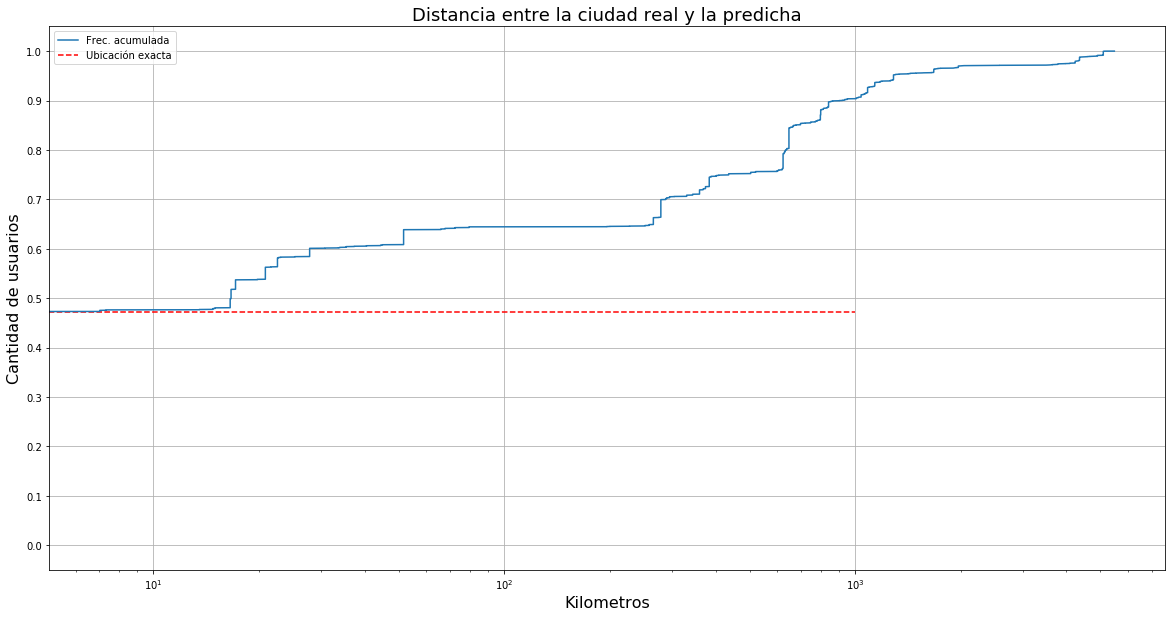

In [50]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

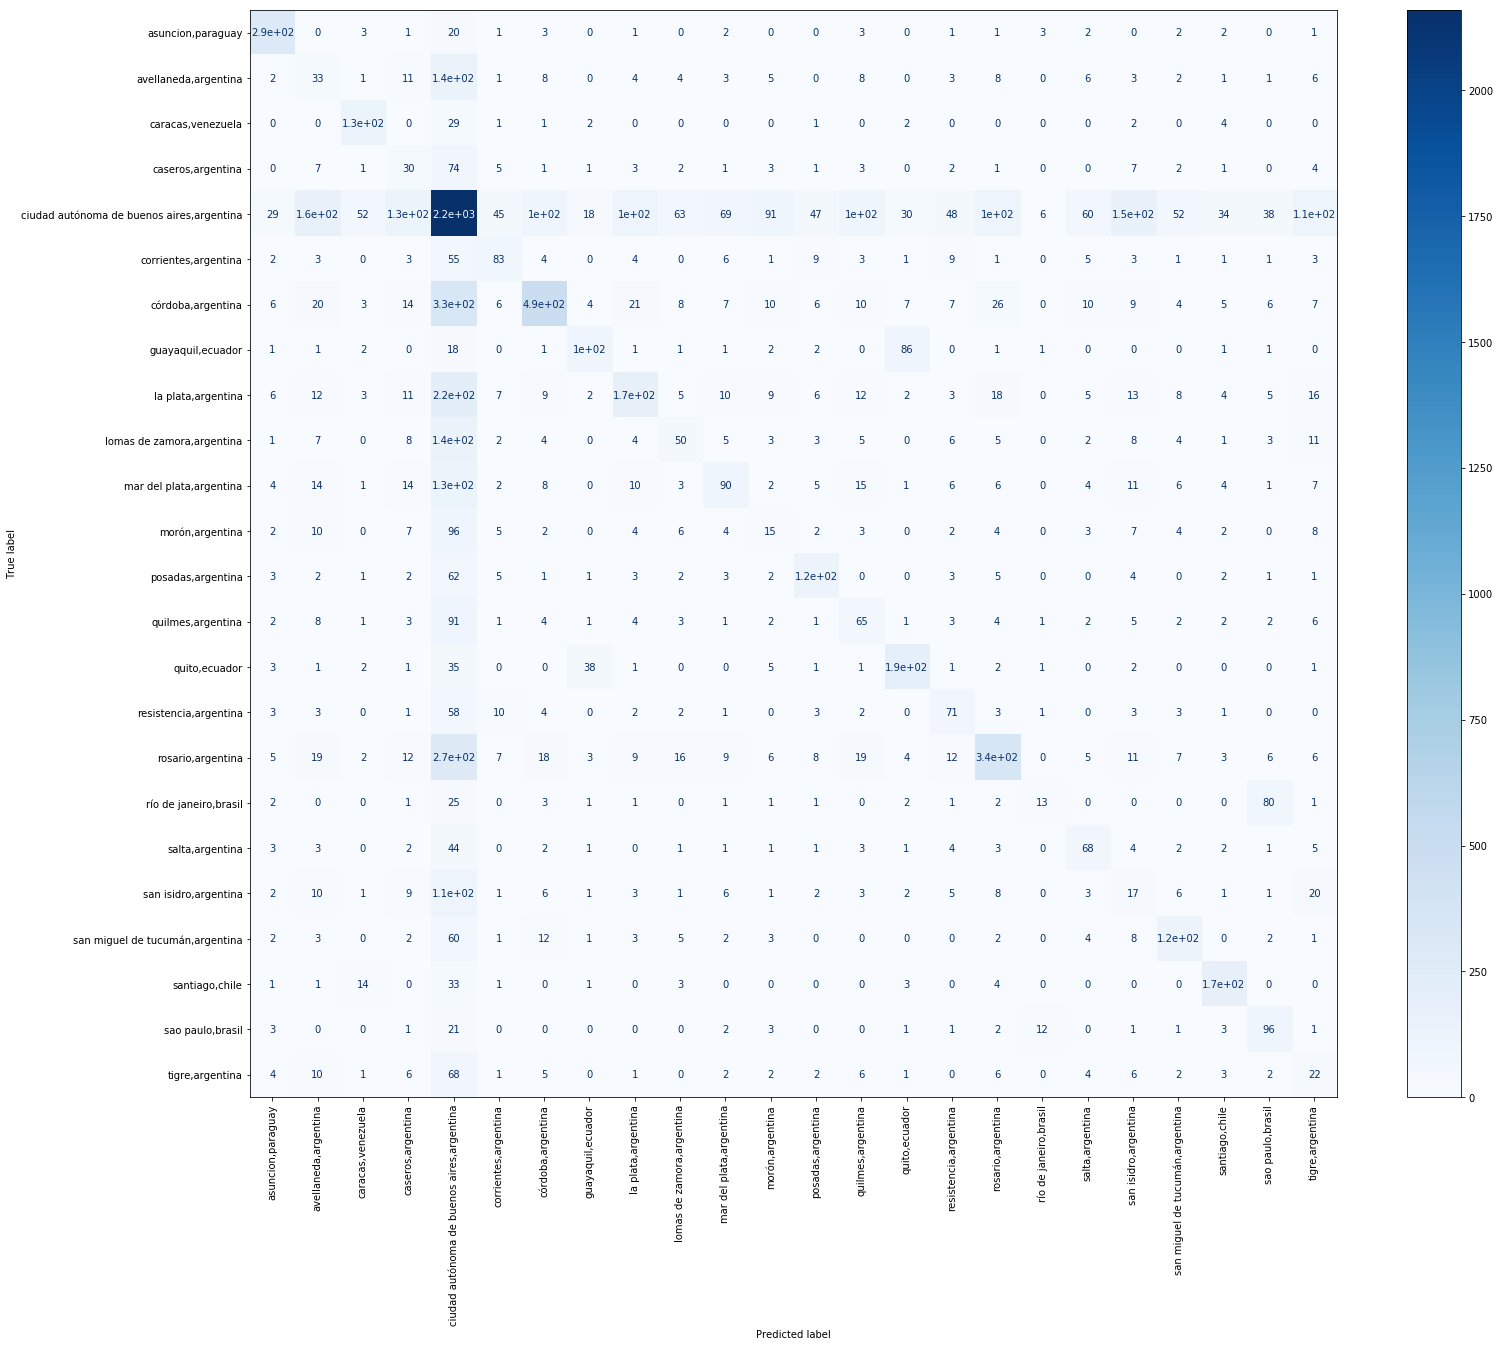

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

In [56]:
logistic = LogisticRegression(n_jobs=2, multi_class='multinomial')

In [57]:
param_grid={'C': [0.5, 1.0], 'class_weight': ['balanced']}
        
grid_drop = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'C': 1.0, 'class_weight': 'balanced'} 0.3176022421193675


In [58]:
y_predicted = grid_drop.predict(X_test)

print("Accuracy in test: {} - Balanced accuracy in test: {}".format(
        accuracy_score(y_test, y_predicted),
        balanced_accuracy_score(y_test, y_predicted)
    )
)

Accuracy in test: 0.3181168441923733 - Balanced accuracy in test: 0.40909313710667927


In [59]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


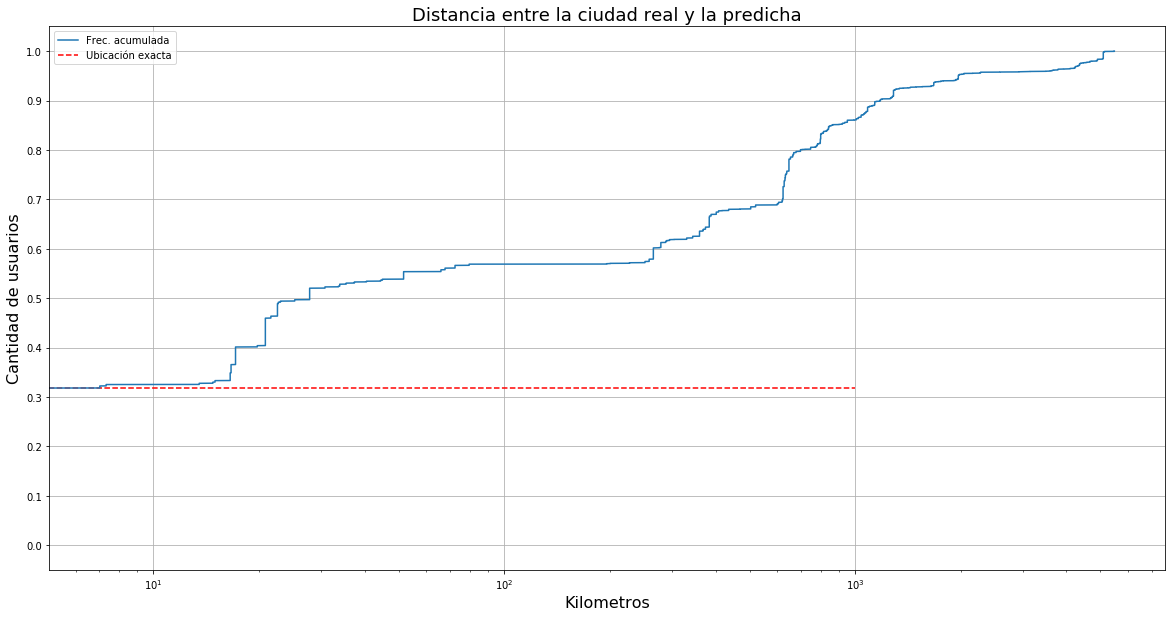

In [60]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

NameError: name 'grid_drop' is not defined

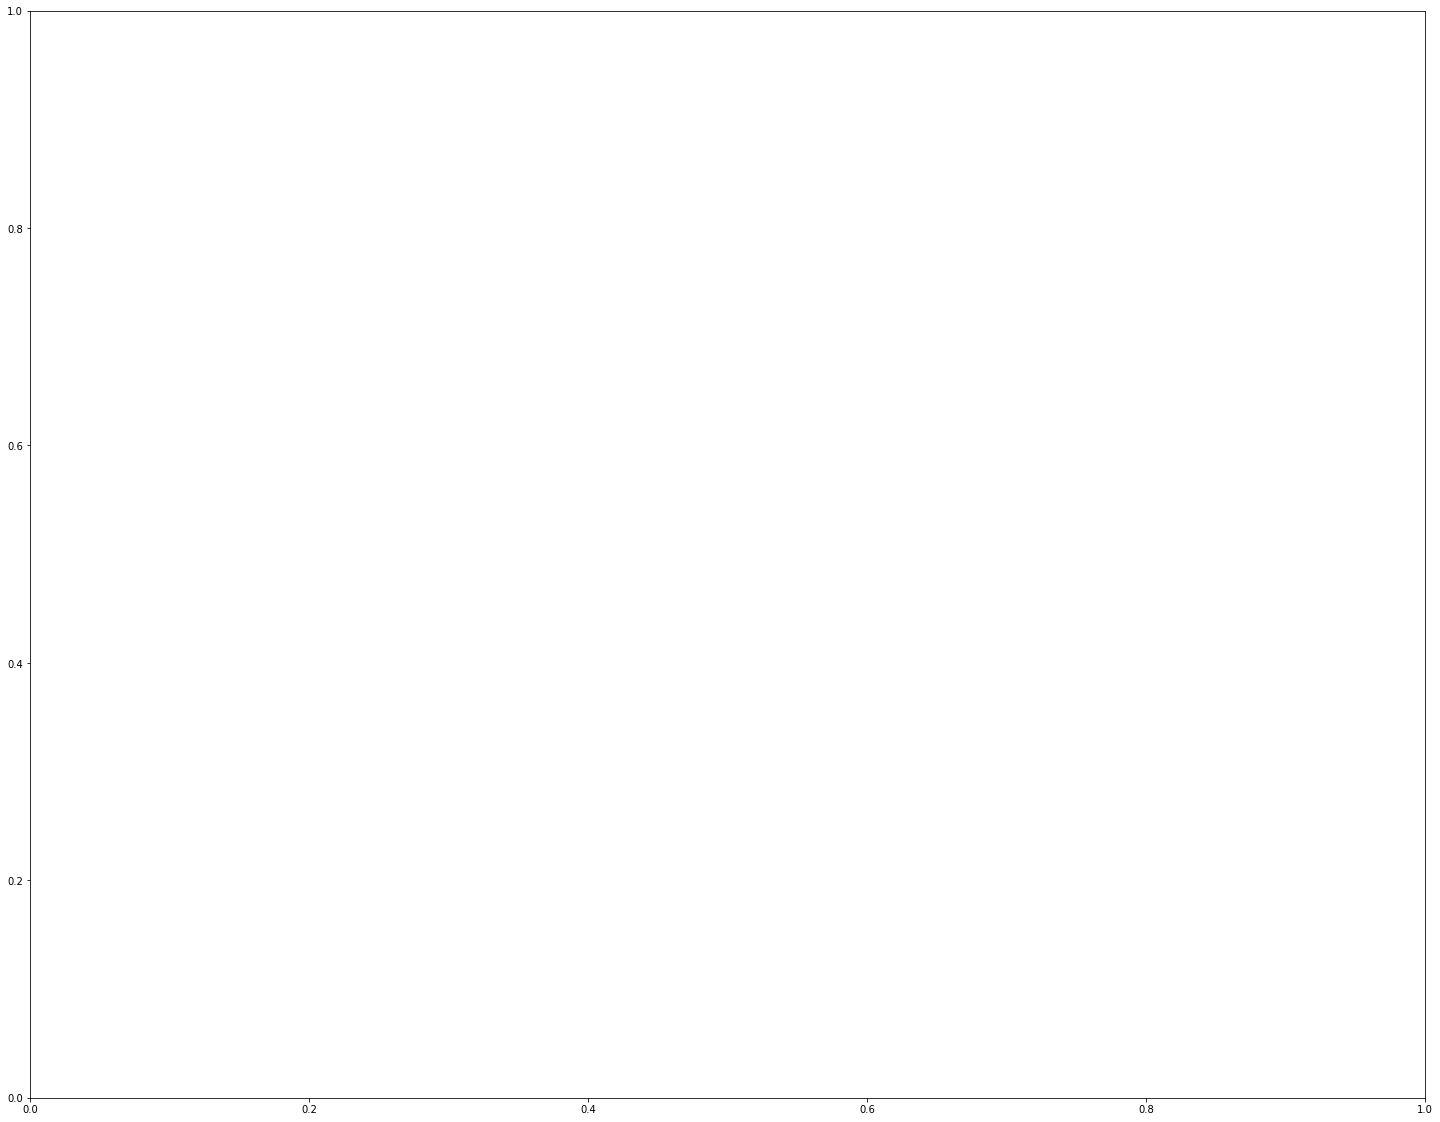

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)